In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#trying to improve pandas plotting output 

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
#get distinct
from sqlalchemy import distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

#Find last row 
last  = session.query(Measurement).order_by(Measurement.date.desc()).first()
last.__dict__
# Last row is 2017-08-23

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x9553240>,
 'prcp': 0.0,
 'station': 'USC00519397',
 'id': 2724,
 'tobs': 81.0,
 'date': '2017-08-23'}

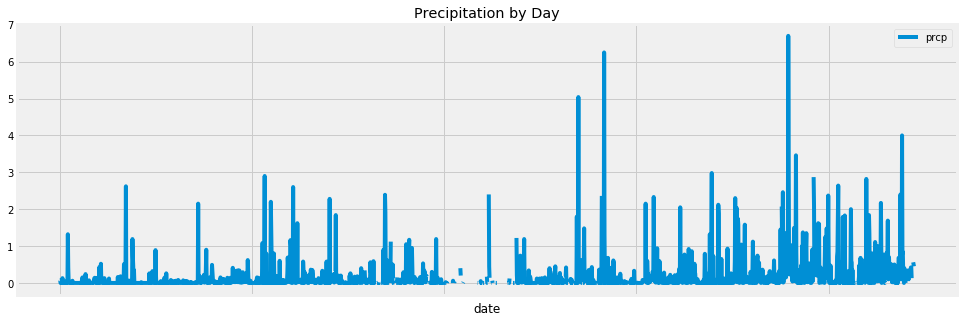

In [11]:


# Perform a query to retrieve the data and precipitation scores

#create variable from timedelta

last_year = (dt.datetime(2017, 8, 23) - dt.timedelta(days=365))

#query prcp data from last year 

lastyear_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).all()
# print(lastyear_prcp)
    
# Save the query results as a Pandas DataFrame and set the index to the date column

lyp_df = pd.DataFrame(lastyear_prcp)

lyp_df.set_index("date", inplace=True)

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(15,5))
lyp_df.plot(ax = ax, title="Precipitation by Day")
plt.show()



![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

lyp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?


for row in session.query(func.count(distinct(Measurement.station))):
    print(row)


(9,)


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?

# for row in session.query(Measurement.station, func.count(Measurement.station)).\
#     group_by(Measurement.station).order_by(func.count.desc.)all():
#     print(row)

for row in session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).all():
    print(row)
    

# List the stations and the counts in descending order.

##still not figuring out the orderby but have values 



('USC00511918', 1979)
('USC00513117', 2709)
('USC00514830', 2202)
('USC00516128', 2612)
('USC00517948', 1372)
('USC00518838', 511)
('USC00519281', 2772)
('USC00519397', 2724)
('USC00519523', 2669)


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()

min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()

avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()

print(f"The highest temperature recorded at Base USC00519281 was {max_temp} degrees.")
print(f"The lowest temperature recorded at Base USC00519281 was {min_temp} degrees.")
print(f"The average temperature at Base USC00519281 was {avg_temp}. degrees")



The highest temperature recorded at Base USC00519281 was [(85.0,)] degrees.
The lowest temperature recorded at Base USC00519281 was [(54.0,)] degrees.
The average temperature at Base USC00519281 was [(71.66378066378067,)]. degrees


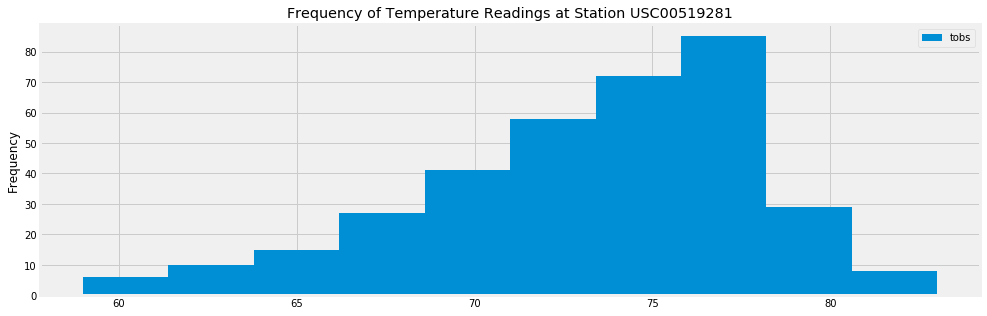

In [16]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

daily_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= last_year,Measurement.station == "USC00519281" ).all()

daily_df = pd.DataFrame(daily_temp)

daily_df.set_index("date", inplace=True)

fig, ax = plt.subplots(figsize=(15,5))
daily_df.plot.hist(ax = ax, title="Frequency of Temperature Readings at Station USC00519281")
plt.show()

#fix legend

![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

tdata=calc_temps("2017-01-04", "2017-01-19")
       
#tmin, tavg, tmax = [0]
[tmin, tavg, tmax] = tdata[0]



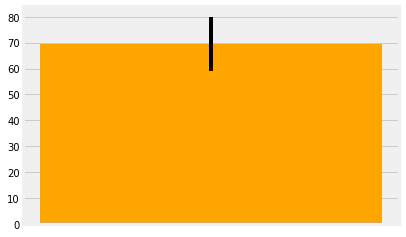

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x = 1


error = ((tmax-tavg)-(tmin-tavg))/2

plt.bar(x, tavg, color = "orange", yerr = error)
ax.set_xticklabels([])
fig.suptitle("Trip Avg Temp")
plt.xticks([])

plt.show()



In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.



# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
